<a href="https://colab.research.google.com/github/GitHub-Aditya14Raj/PRODIGY_GAI_04/blob/main/Task_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install tensorflow numpy matplotlib tensorflow-datasets


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
import os
import time
from IPython.display import display
import tensorflow_datasets as tfds


In [ ]:
import tensorflow_datasets as tfds

dataset, info = tfds.load('cycle_gan/facades', with_info=True, as_supervised=True)

def preprocess_image(image, label):
    # Normalize images to range [-1, 1]
    input_image = tf.cast(image, tf.float32)
    input_image = (input_image / 127.5) - 1
    label_image = tf.cast(label, tf.float32)
    label_image = (label_image / 127.5) - 1
    return input_image, label_image

train_dataset_A = dataset['trainA'].map(preprocess_image, num_parallel_calls=tf.data.experimental.AUTOTUNE).shuffle(400).batch(1)
train_dataset_B = dataset['trainB'].map(preprocess_image, num_parallel_calls=tf.data.experimental.AUTOTUNE).shuffle(400).batch(1)


In [ ]:
dataset, info = tfds.load('cycle_gan/facades', with_info=True, as_supervised=True)
print(info)



tfds.core.DatasetInfo(
    name='cycle_gan',
    full_name='cycle_gan/facades/3.0.0',
    description="""
    A dataset consisting of images from two classes A and B (For example: horses/zebras, apple/orange,...)
    """,
    homepage='https://junyanz.github.io/CycleGAN/',
    data_dir='/root/tensorflow_datasets/cycle_gan/facades/3.0.0',
    file_format=tfrecord,
    download_size=33.51 MiB,
    dataset_size=34.83 MiB,
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=2),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'testA': <SplitInfo num_examples=106, num_shards=1>,
        'testB': <SplitInfo num_examples=106, num_shards=1>,
        'trainA': <SplitInfo num_examples=400, num_shards=1>,
        'trainB': <SplitInfo num_examples=400, num_shards=1>,
    },
    citation="""@article{DBLP:journals/corr/ZhuPIE17,
      author    = {Jun{-}

In [ ]:
from tensorflow.keras.layers import Input, Concatenate, Conv2D, Conv2DTranspose, BatchNormalization, LeakyReLU, Dropout, Activation
from tensorflow.keras.models import Model

# Generator function
def build_generator():
    # Encoder
    input_shape = (256, 256, 3)
    inputs = Input(shape=input_shape, name='input_image')

    # Downsampling blocks
    encoder_layers = [
        (64, False),   # (bs, 128, 128, 64)
        (128, True),   # (bs, 64, 64, 128)
        (256, True),   # (bs, 32, 32, 256)
        (512, True),   # (bs, 16, 16, 512)
        (512, True),   # (bs, 8, 8, 512)
        (512, True),   # (bs, 4, 4, 512)
        (512, True),   # (bs, 2, 2, 512)
        (512, True),   # (bs, 1, 1, 512)
    ]

    skips = []
    x = inputs
    for filters, batch_norm in encoder_layers:
        x = Conv2D(filters, kernel_size=4, strides=2, padding='same', use_bias=not batch_norm)(x)
        if batch_norm:
            x = BatchNormalization()(x)
        x = LeakyReLU(alpha=0.2)(x)
        skips.append(x)

    # Bottleneck
    x = Conv2D(512, kernel_size=4, strides=2, padding='same', use_bias=False)(x)
    x = Activation('relu')(x)

    # Decoder
    decoder_layers = [
        (512, True),   # (bs, 2, 2, 1024)
        (512, True),   # (bs, 4, 4, 1024)
        (512, True),   # (bs, 8, 8, 1024)
        (512, False),  # (bs, 16, 16, 1024)
        (256, False),  # (bs, 32, 32, 512)
        (128, False),  # (bs, 64, 64, 256)
        (64, False),   # (bs, 128, 128, 128)
    ]

    decoder_layers = list(reversed(decoder_layers))
    for filters, dropout in decoder_layers:
        x = Conv2DTranspose(filters, kernel_size=4, strides=2, padding='same', use_bias=False)(x)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)
        if dropout:
            x = Dropout(0.5)(x)
        skip_connection = skips.pop()


        if x.shape[1:3] != skip_connection.shape[1:3]:
            skip_connection = Conv2DTranspose(filters, kernel_size=4, strides=2, padding='same', use_bias=False)(skip_connection)


        if x.shape[1:3] != skip_connection.shape[1:3]:
            raise ValueError(f"Shapes mismatch between x {x.shape} and skip_connection {skip_connection.shape}")

        x = Concatenate()([x, skip_connection])


    outputs = Conv2DTranspose(3, kernel_size=4, strides=2, padding='same', activation='tanh')(x)


    generator = Model(inputs=inputs, outputs=outputs, name='generator')
    return generator


generator = build_generator()


In [ ]:
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.optimizers import Adam

# Loss function
bce_loss = BinaryCrossentropy(from_logits=True)

# Generator loss
def generator_loss(disc_generated_output, gen_output, target):
    gan_loss = bce_loss(tf.ones_like(disc_generated_output), disc_generated_output)
    # Mean absolute error
    l1_loss = tf.reduce_mean(tf.abs(target - gen_output))
    total_gen_loss = gan_loss + (100 * l1_loss)  # Adjust the lambda value as needed
    return total_gen_loss

# Discriminator loss
def discriminator_loss(disc_real_output, disc_generated_output):
    real_loss = bce_loss(tf.ones_like(disc_real_output), disc_real_output)
    generated_loss = bce_loss(tf.zeros_like(disc_generated_output), disc_generated_output)
    total_disc_loss = real_loss + generated_loss
    return total_disc_loss

# Optimizers
generator_optimizer = Adam(2e-4, beta_1=0.5)
discriminator_optimizer = Adam(2e-4, beta_1=0.5)


In [ ]:
@tf.function
def train_step(input_image, target):
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        # Generate fake image
        gen_output = generator(input_image, training=True)

        # Get discriminator output
        disc_real_output = discriminator(target, training=True)
        disc_generated_output = discriminator(gen_output, training=True)

        # Calculate losses
        gen_loss = generator_loss(disc_generated_output, gen_output, target)
        disc_loss = discriminator_loss(disc_real_output, disc_generated_output)

    # Calculate gradients
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    # Apply gradients
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss


1/1 [==============================] - 0s 65ms/step


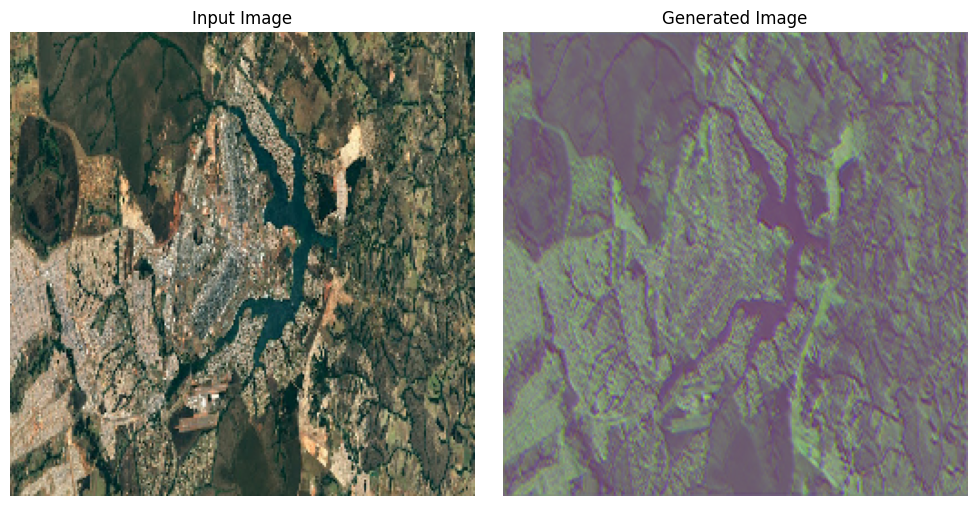

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.preprocessing import image as keras_image

input_image_path = '/content/map.jpg'
input_image = keras_image.load_img(input_image_path, target_size=(256, 256))
input_image = keras_image.img_to_array(input_image)
input_image = (input_image / 127.5) - 1.0  # Normalize pixel values to [-1, 1]
input_image = np.expand_dims(input_image, axis=0)  # Add batch dimension

generated_image = generator.predict(input_image)

input_image = np.squeeze(input_image)
generated_image = np.squeeze(generated_image)
generated_image = (generated_image + 1.0) * 127.5
generated_image = np.clip(generated_image, 0, 255).astype(np.uint8)

plt.figure(figsize=(10, 5))

# Plotting the input image
plt.subplot(1, 2, 1)
plt.imshow((input_image + 1.0) / 2.0)
plt.title('Input Image')
plt.axis('off')

# Plotting the generated image
plt.subplot(1, 2, 2)
plt.imshow(generated_image)
plt.title('Generated Image')
plt.axis('off')

plt.tight_layout()
plt.show()

plt.imsave('generated_image.png', generated_image)
